In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# Import some modules from other libraries
import numpy as np
import random
import torch
import time
import matplotlib.pyplot as plt
from collections import deque

# Import the environment module
from environment import Environment
from qnetworkviz import QNetworkViz

In [3]:
# The Agent class allows the agent to interact with the environment.
class Agent:

    # The class initialisation function.
    def __init__(self, environment):
        # Set the agent's environment.
        self.environment = environment
        # Create the agent's current state
        self.state = None
        # Create the agent's total reward for the current episode.
        self.total_reward = None
        # Reset the agent.
        self.reset()

    # Function to reset the environment, and set the agent to its initial state. This should be done at the start of every episode.
    def reset(self):
        # Reset the environment for the start of the new episode, and set the agent's state to the initial state as defined by the environment.
        self.state = self.environment.reset()
        # Set the agent's total reward for this episode to zero.
        self.total_reward = 0.0
        

    # Function to make the agent take one step in the environment.
    def step(self,mode,epsilon=None,action=None):
        # Choose an action.
        if mode == "random":
            discrete_action = np.random.randint(4)
            
        elif mode == "egreedy":
            actions = np.arange(0,4)
            probas = np.ones(4)*(epsilon/4)
            probas[action] = 1-epsilon + (epsilon/4)
            discrete_action = np.random.choice(actions,p=probas)
        
        else:
            raise ValueError("mode must be in [random,egreedy]")
            
        # Convert the discrete action into a continuous action.
        continuous_action = self._discrete_action_to_continuous(discrete_action)
        # Take one step in the environment, using this continuous action, based on the agent's current state. This returns the next state, and the new distance to the goal from this new state. It also draws the environment, if display=True was set when creating the environment object..
        next_state, distance_to_goal = self.environment.step(self.state, continuous_action)
        # Compute the reward for this paction.
        reward = self._compute_reward(distance_to_goal)
        # Create a transition tuple for this step.
        transition = (self.state, discrete_action, reward, next_state)
        # Set the agent's state for the next step, as the next state from this step
        self.state = next_state
        # Update the agent's reward for this episode
        self.total_reward += reward
        # Return the transition
        return transition

    # Function for the agent to compute its reward. In this example, the reward is based on the agent's distance to the goal after the agent takes an action.
    def _compute_reward(self, distance_to_goal):
        reward = 1 - distance_to_goal
        return reward

    # Function to convert discrete action (as used by a DQN) to a continuous action (as used by the environment).
    def _discrete_action_to_continuous(self, discrete_action):
        if discrete_action == 0:  # Move right
            continuous_action = np.array([0.1, 0], dtype=np.float32)
        elif discrete_action == 1:#Move down
            continuous_action = np.array([0, -0.1], dtype=np.float32)
        elif discrete_action == 2:#Move left
            continuous_action = np.array([-0.1, 0], dtype=np.float32)
        else :#Move up
            continuous_action = np.array([0, 0.1], dtype=np.float32)
        return continuous_action


In [4]:
# The Network class inherits the torch.nn.Module class, which represents a neural network.
class Network(torch.nn.Module):

    # The class initialisation function. This takes as arguments the dimension of the network's input (i.e. the dimension of the state), and the dimension of the network's output (i.e. the dimension of the action).
    def __init__(self, input_dimension, output_dimension):
        # Call the initialisation function of the parent class.
        super(Network, self).__init__()
        # Define the network layers. This example network has two hidden layers, each with 100 units.
        self.layer_1 = torch.nn.Linear(in_features=input_dimension, out_features=100)
        self.layer_2 = torch.nn.Linear(in_features=100, out_features=100)
        self.output_layer = torch.nn.Linear(in_features=100, out_features=output_dimension)

    # Function which sends some input data through the network and returns the network's output. In this example, a ReLU activation function is used for both hidden layers, but the output layer has no activation function (it is just a linear layer).
    def forward(self, input):
        layer_1_output = torch.nn.functional.relu(self.layer_1(input))
        layer_2_output = torch.nn.functional.relu(self.layer_2(layer_1_output))
        output = self.output_layer(layer_2_output)
        return output

class ReplayBuffer(deque):
    def __init__(self,min_size):
        super().__init__([],10**6)
        self.min_size = min_size

    def is_full_enough(self):
        return len(self)>=self.min_size

    def get_minibatch(self):
        try:
            minibatch = random.sample(self,k=self.min_size)
        except:
            raise ValueError("Replay Buffer is not full enough")

        return minibatch

In [5]:
# The DQN class determines how to train the above neural network.
class DQN:

    # The class initialisation function.
    def __init__(self):
        # Create a Q-network, which predicts the q-value for a particular state.
        self.q_network = Network(input_dimension=3, output_dimension=1)
        # Define the optimiser which is used when updating the Q-network. The learning rate determines how big each gradient step is during backpropagation.
        self.optimiser = torch.optim.Adam(self.q_network.parameters(), lr=0.001)

    # Function that is called whenever we want to train the Q-network. Each call to this function takes in a transition tuple containing the data we use to update the Q-network.
    def train_q_network(self, transition):
        # Set all the gradients stored in the optimiser to zero.
        self.optimiser.zero_grad()
        # Calculate the loss for this transition.
        loss = self._calculate_loss(transition)
        # Compute the gradients based on this loss, i.e. the gradients of the loss with respect to the Q-network parameters.
        loss.backward()
        # Take one gradient step to update the Q-network.
        self.optimiser.step()
        # Return the loss as a scalar
        loss_value = loss.item()
        return loss_value

    # Function to calculate the loss for a particular transition.
    def _calculate_loss(self,transition):

        batch_size = len(transition)
        input_batch = np.array([])
        reward_batch = np.array([])
        
        for single_transition in transition:
            state,action,reward = single_transition[0],single_transition[1],single_transition[2]
            input_batch  = np.append(input_batch,np.append(state,action).reshape(3))
            reward_batch = np.append(reward_batch,reward)

        input_batch = input_batch.reshape(len(transition),3).astype(np.float32)
        reward_batch = reward_batch.reshape(len(transition),1).astype(np.float32)

        input_tensor = torch.tensor(input_batch)
        reward_tensor = torch.tensor(reward_batch)
        network_prediction = self.q_network.forward(input_tensor)
        loss = torch.nn.MSELoss()(network_prediction, reward_tensor)

        return loss
    
    def get_greedy_action(self,state):
        best_reward = -100
        best_action = -100
        
        for i in range(4):
            input_state_action = np.append(state,i).reshape(1,3).astype(np.float32)
            input_tensor = torch.tensor(input_state_action)
            predicted_reward = self.q_network.forward(input_tensor)
            
            if predicted_reward>best_reward:
                best_reward = predicted_reward
                best_action = i
                
        return best_action
    
    def get_qvalues(self):
        qvalues = np.zeros((10,10,4))
        for i in range(10):
            for j in range(10):
                for action in range(4):
                    input_state_action = np.array([(0.05 + i*0.1),(0.05 + j*0.1),action]).reshape(1,3).astype(np.float32)
                    input_tensor = torch.tensor(input_state_action)
                    predicted_qvalue = self.q_network.forward(input_tensor)
                    qvalues[i,j,action] = predicted_qvalue
        return qvalues
                

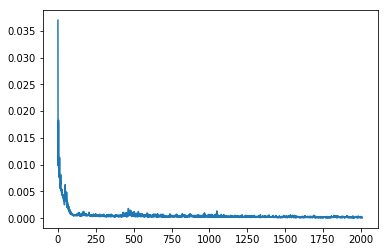

In [6]:
CID = 799240
random.seed(CID)
torch.manual_seed(CID)

environment = Environment(display=False, magnification=500)
agent = Agent(environment)
dqn = DQN()
replay_buffer = ReplayBuffer(min_size=50)
n_steps = 0
loss_vect = []

while n_steps<=2000:
    # Reset the environment for the start of the episode.
    agent.reset()
    # Loop over steps within this episode. The episode length here is 20.
    for step_num in range(20):
        # Step the agent once, and get the transition tuple for this step
        if not replay_buffer.is_full_enough():
            transition = agent.step('random')
            replay_buffer.append(transition)
        else:
            best_action = dqn.get_greedy_action(agent.state)
            transition = agent.step('random')
            #transition = agent.step('egreedy',epsilon = 1/(1+(n_steps%20)), action=best_action)
            replay_buffer.append(transition)
            mini_batch = replay_buffer.get_minibatch()
            loss = dqn.train_q_network(mini_batch)
            n_steps+=1
            loss_vect+=[loss]
            
plt.plot(np.arange(0,n_steps),loss_vect)
plt.show()

In [7]:
### Test greedy policy

test_env = environment = Environment(display=True, magnification=500)
agent = Agent(test_env)
agent.reset()
greedy_path = np.array([agent.state])
time.sleep(1)
for step_num in range(20):
    best_action = dqn.get_greedy_action(agent.state)
    transition = agent.step('egreedy',epsilon = 0, action=best_action)
    greedy_path = np.append(greedy_path,[agent.state],axis=0)
    
print(greedy_path)

[[0.15       0.15      ]
 [0.15       0.25      ]
 [0.15       0.35      ]
 [0.15       0.45      ]
 [0.15       0.55      ]
 [0.25       0.55      ]
 [0.25       0.65000004]
 [0.35       0.65000004]
 [0.45       0.65000004]
 [0.55       0.65000004]
 [0.65000004 0.65000004]
 [0.65000004 0.75000006]
 [0.75000006 0.75000006]
 [0.8500001  0.75000006]
 [0.8500001  0.8500001 ]
 [0.9500001  0.8500001 ]
 [0.9500001  0.9500001 ]
 [0.9500001  0.9500001 ]
 [0.9500001  0.9500001 ]
 [0.9500001  0.9500001 ]
 [0.9500001  0.9500001 ]]


In [8]:
viz = QNetworkViz()

In [9]:
viz.plot_q_values(dqn.get_qvalues())
viz.plot_grid()
viz.plot_path(greedy_path)
viz.show()